In [188]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from wordcloud import WordCloud
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score
import nltk
import torch

#used packages
import tensorflow as tf
import pandas as pd

#BERT Packages
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import InputExample, InputFeatures

In [90]:
df = pd.read_csv('dataset/tweet_product_company.csv', encoding = 'iso-8859-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [91]:
#rename columns
df2 = df.rename(columns = {'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment',
                           'tweet_text':'Twitter_Post', 'emotion_in_tweet_is_directed_at':'Focus'})

In [92]:
df2.head()

,Twitter_Post,Focus,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Understanding Data

In [93]:
#Dataframe Information
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Twitter_Post  9092 non-null   object
 1   Focus         3291 non-null   object
 2   Sentiment     9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [94]:
#Count of misssing data
df2.isnull().sum()

Twitter_Post       1
Focus           5802
Sentiment          0
dtype: int64

In [95]:
#FILL Missing values
df2['Focus'] = df2['Focus'].fillna("")
df2['Twitter_Post'] = df2['Twitter_Post'].fillna("")

In [96]:
#verification of missing null values is removed
df2.isnull().sum()

Twitter_Post    0
Focus           0
Sentiment       0
dtype: int64

### Univariate Distribution of the Sentiments & Focus group
Data visualization of the different sentiments and Focus group in the dataframe.

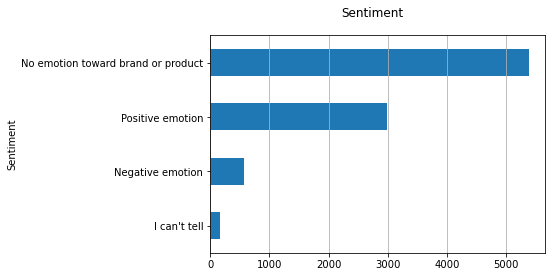

In [97]:
#Distribution of the different Sentiments
fig, ax = plt.subplots()
fig.suptitle("Sentiment", fontsize=12)
df2["Sentiment"].reset_index().groupby("Sentiment").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

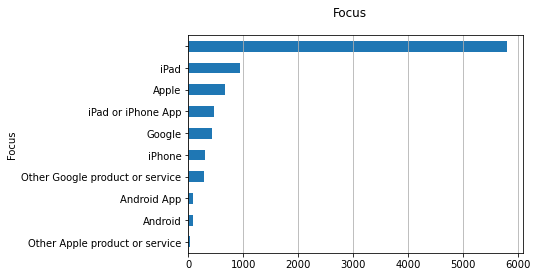

In [98]:
#Distribution of focus the group.
fig, ax = plt.subplots()
fig.suptitle("Focus", fontsize=12)
df2["Focus"].reset_index().groupby("Focus").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

### Text Cleaning / PreProcessing

In [99]:
#removing quotiation marks, special characters and numbers
df2['Twitter_Post'] = df2['Twitter_Post'].str.replace("[^a-zA-Z]", " ")

In [100]:
#removing short words, less than 3 characters in length.
df2['Twitter_Post'] = df2['Twitter_Post'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))

In [101]:
#Applying lower case function

#creating lowercase function
def lowercase (text):
    text = [word.lower() for word in text.split(' ')]
    text = " ".join(text)
    return text

df2['Twitter_Post'] = df2['Twitter_Post'].apply(lowercase)

In [102]:
#removing Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df2['Twitter_Post'] = df2['Twitter_Post'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/carlosmarin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [103]:
#Applying Stemming

#Assigning Variable
stemmer = nltk.SnowballStemmer("english")

#creating stem function
def stem (text):
    text = [stemmer.stem(word) for word in text.split(' ')]
    text = " ".join(text)
    return text

#Application of stemming function
df2['Twitter_Post'] = df2['Twitter_Post'].apply(stem)

In [104]:
#Applying Lemmatization

#Assigining variable 
lemmatizer = WordNetLemmatizer()

#creating lemmatization function
def lemmatization(text):
    text = [lemmatizer.lemmatize(word) for word in text.split(' ')]
    text = " ".join(text)
    return text

df2['Twitter_Post'] = df2['Twitter_Post'].apply(lemmatization)

### encoding labels

In [105]:
possible_labels = df2.Sentiment.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Negative emotion': 0,
 'Positive emotion': 1,
 'No emotion toward brand or product': 2,
 "I can't tell": 3}

In [106]:
df2['label'] = df2.Sentiment.replace(label_dict)

In [107]:
df2.head()

,Twitter_Post,Focus,Sentiment,label
0,".@wesley83 iphone. tweet #rise_austin, dead! n...",iPhone,Negative emotion,0
1,@jessede know @fludapp awesom ipad/iphon like ...,iPad or iPhone App,Positive emotion,1
2,@swonderlin wait #ipad also. sale #sxsw.,iPad,Positive emotion,1
3,@sxsw hope year festiv crashi year iphon app. ...,iPad or iPhone App,Negative emotion,0
4,@sxtxstate great stuff #sxsw: marissa mayer (g...,Google,Positive emotion,1


### Word Clouds

### BertTokenizer and Encoding the Data

In [144]:
train_data, test_data = train_test_split(df2, test_size = 0.20, random_state = 777)

In [152]:
reviews = train_data['Twitter_Post']
target = train_data['label']


test_reviews = test_data['Twitter_Post']
test_target = test_data['label']

In [153]:
#creating BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [166]:
encoded_data_train = tokenizer.batch_encode_plus(
    reviews.values,
    padding = True,
    pad_to_max_length= True,
    add_special_tokens = True,
    return_attention_mask = True,
    max_length = 256,
    return_tensors = 'pt')


encoded_data_test = tokenizer.batch_encode_plus(
    test_reviews.values,
    padding = True,
    pad_to_max_length= True,
    add_special_tokens = True,
    return_attention_mask = True,
    max_length = 256,
    return_tensors = 'pt')

In [167]:
#splitting the training data into input_ids, attention_masks and labels.
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(target.values)

#splitting the test data into input_ids, attention_masks and labels.
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_target.values)

In [169]:
from torch.utils.data import TensorDataset
dataset_train = TensorDataset(input_ids_train,attention_masks_train,labels_train )

dataset_test = TensorDataset(input_ids_test,attention_masks_test,labels_test )

In [179]:
#creating base BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                       num_labels = len(label_dict), 
                                                       output_attentions = False,
                                                       output_hidden_states = False)

### Data Loaders
**DataLoader** combines a dataset and a sampler, and provides an iterable over the given dataset.

We use **RandomSampler** for training and **SequentialSampler** for validation.

Given the limited memory in my environment, I set **batch_size=3**

In [172]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                             sampler = RandomSampler(dataset_train),
                             batch_size = batch_size)

dataloader_test = DataLoader(dataset_test, 
                             sampler = SequentialSampler(dataset_train),
                             batch_size = batch_size)

### Optimizer & Scheduler
To construct an optimizer, we have to give it an iterable containing the parameters to optimize. Then, we can specify optimizer-specific options such as the learning rate, epsilon, etc.

I found epochs=5 works well for this data set.

Create a schedule with a learning rate that decreases linearly from the initial learning rate set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial learning rate set in the optimizer.

In [183]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8)

epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0,
                                  num_training_steps = len(dataloader_train)*epochs)

### performance Metrics
Using f1 score and accuracy per class as performance metrics

In [189]:
from sklearn.metrics import f1_score


def f1_score_func(preds,labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

def accuracy_per_class(preds, labels):
    label_dict_inv = {v: k  for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds == label])}/{len(y_true)}\n')

### Training Loop

In [198]:
import random
from tqdm.notebook import tqdm

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [199]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [200]:
print(device)

cpu


In [201]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [202]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2425 [00:00<?, ?it/s]

RuntimeError: Parent directory data_volume does not exist.